In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta

from collections import Counter
import itertools

import networkx as nx

a4_dims = (11.7, 8.27)
windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']

In [2]:
events = {'2016-11-09': 'Trump wins election', \
          '2017-08-11': 'Unite the Right rally', \
          '2017-11-21': 'Plan to repeal net neutrality', \
          '2017-12-18': 'Twitter suspends white nationalists', \
          '2018-01-12': 'Trump "shithole" comment', \
          '2018-03-01': 'Gilmore lawsuit against Alex Jones'}

In [3]:
def get_df(json_file):
    x = json.load(open(json_file))
    x = pd.DataFrame(x['views'])
    #x = x.drop(['_id'],axis=1)
    x['time'] = pd.to_datetime(x['time'],unit='ms')
    x['index'] = pd.to_datetime(x['time'],unit='ms')
    x.set_index('index', inplace=True)
    return x

def prepare_file(fname):
    startOfFile = "{\"views\":["
    endOfFile = "]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open("tmp.json",'w') as tmp:
        tmp.write(data.pop(0).strip()+",\n")
        while len(data)>1:
            tmp.write(data.pop(0).strip()+",\n")
        tmp.write(data.pop(0).strip()+endOfFile)
        tmp.close()

def prepare_degree_file(fname):
    windows.reverse()
    startOfFile = "{\"views\":["
    endOfFile = "}]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open("degree/tmp.json",'w') as tmp:
        i = 0
        tmp.write(startOfFile+data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+"},\n")
        i+=1
        while len(data)>1:
            tmp.write(data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+"},\n")
            i+=1
        tmp.write(data.pop(0).strip().strip("}")+",\"windowsize\":"+str(windows[i%4])+endOfFile)
        tmp.close()
        
def prepare_pr_file(fname):
    windows.reverse()
    startOfFile = "{\"views\":["
    endOfFile = "]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open("degree/tmp.json",'w') as tmp:
        i = 0
        while len(data)>1:
            tmp.write(data.pop(0).strip()+",\n")
            i+=1
        tmp.write(data.pop(0).strip()+endOfFile)
        tmp.close()

# Weighted Page Rank Results

In [4]:
def get_rank(rankings, user):
    rank = 10
    for row in rankings:
        if row['id']==user:
            return rank
        rank-=1
    return rank

def get_pagerank(rankings, user):
    for row in rankings:
        if row['id']==user:
            return row['pagerank']
    return None

def get_trajectory(user, pr):
    traj = np.asarray(list(pr['bestusers'].apply(lambda row: get_rank(row,user))))
    return traj

def get_pr_trajectory(user,pr):
    traj = np.asarray(list(pr['bestusers'].apply(lambda row: get_pagerank(row,user))))
    return traj

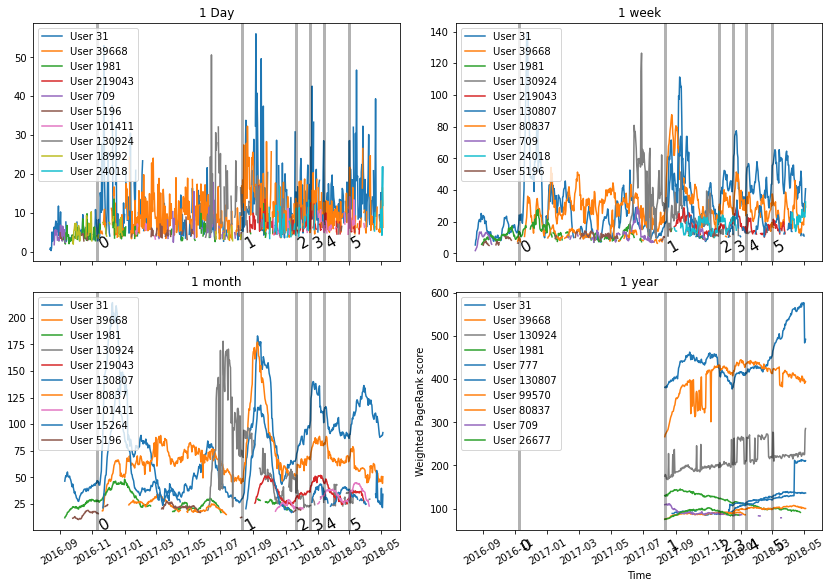

In [5]:
from collections import defaultdict

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=a4_dims, sharex=True)
plt.xticks(rotation=30)

start, end = '2016-07-30 23:00:00','2018-05-30'

file = "degree/WeightedPageRank.json"
prepare_pr_file(file)
pagerank = get_df("degree/tmp.json")

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
linecols = defaultdict(lambda : next(ax._get_lines.prop_cycler)['color'])

for i, ax in enumerate(axes.flatten()):
    window = windows[i]
    name = window_names[i]
    y = pagerank
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*window))
    y=y[mask]
    y['time'] = y['time'] - timedelta(microseconds=500*i)
    pr = y[y['windowsize']==window]
    times = np.asarray(pr['time'])
    all_users = list(itertools.chain.from_iterable(pr['bestusers'].tolist()))
    unique_users = list(map(lambda y:y[0],Counter(list(map(lambda row: row['id'], all_users))).most_common(10)))
    #unique_users = (31,4987,1981,709,1175,18992,491,5196,1759,4555)
    for user in list(unique_users):
        ax.plot(times,get_pr_trajectory(user,pr),label="User "+str(user), color=linecols[user])
    index=0
    for event in events.keys(): 
        ax.axvline(x=event, color='black', alpha=0.3, linewidth=3)
        ax.text(event, 0.8, str(index), rotation=30, fontsize=15)
        index +=1
    ax.set_title(name)
    ax.xaxis.set_tick_params(rotation=30)
    ax.legend()
    
plt.xlabel('Time')
plt.ylabel('Weighted PageRank score')
plt.tight_layout()
plt.show()

In [202]:
def get_degree(rankings, user):
    for row in rankings:
        if row['id']==user:
            return row['indegree']
    return None

def get_deg_trajectory(user, pr):
    traj = np.asarray(list(pr['TopUsers'].apply(lambda row: get_degree(row,user))))/pr['vertices']
    return traj

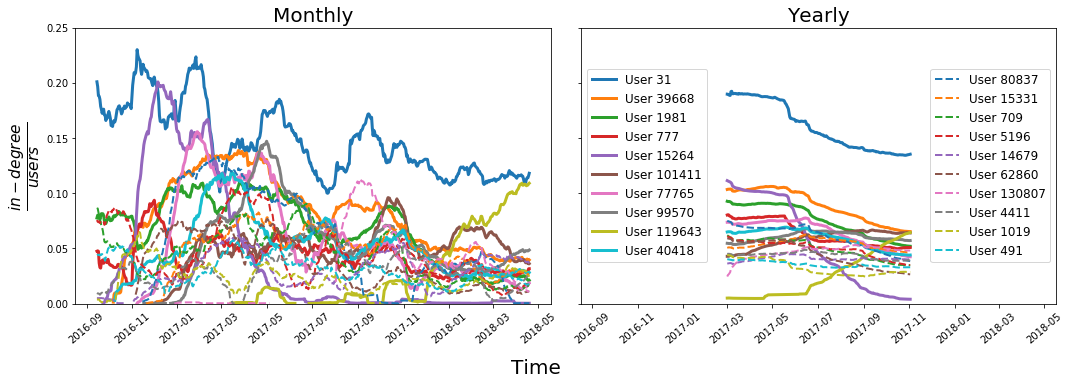

In [256]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5), sharex=True, sharey=True)

file = "degree/gab-selective-degree.json"
vfile = "degree/degreewindows.json"

start, end = '2016-08-30 23:00:00','2018-05-03 23:00:00'

degree, vertices = get_df(file), get_df(vfile)
degree, vertices = degree[start:end], vertices[start:end]

windows = [2592000000, 31536000000]
window_names = ['Monthly', 'Yearly']

linecols = defaultdict(lambda : next(ax._get_lines.prop_cycler)['color'])

for i, ax in enumerate(axes.flatten()):
    #ax.set_xlabel('Time',fontsize=20)
    window = windows[i]
    name = window_names[i]
    y, z = degree, vertices
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(microseconds=1000*window))
    y=y[mask]
    mask = (z['time']>=start) & (z['time'] <= end) & (z['time'] >= z.iloc[0]['time'] + timedelta(microseconds=1000*window))
    z=z[mask]
    y['time'] = y['time'] - timedelta(microseconds=500*window)
    z['time'] = z['time'] - timedelta(microseconds=500*window)
    #mo = y[y['windowsize']==window]
    mo = y[y['windowsize']==window]
    z = z[z['windowsize']==window]
    mo['vertices']=z['vertices']
    #indeg = mo.apply(lambda t: (pd.DataFrame(t.TopUsers).set_index('id').indegree/ t.vertices).to_dict(), axis=1)
    #ideg = indeg.apply(pd.Series)
    #top = ideg.max().sort_values(ascending=False).index[:20]
    top = [31, 39668, 1981, 777, 15264, 101411, 77765, 99570, 119643, 40418, 80837, 15331, 709, 5196, 14679, 62860, 130807, 4411, 1019, 491]
    times = np.asarray(mo['time'])
    #all_users = list(itertools.chain.from_iterable(pr['TopUsers'].tolist()))
    #unique_users = list(map(lambda y:y[0],Counter(list(map(lambda row: row['id'], all_users))).most_common(30)))
    #unique_users = (31,4987,1981,709,1175,18992,491,5196,1759,4555)
    left_user_labels, right_user_labels = [], []
    left_user_plots, right_user_plots = [], []
    for k, user in enumerate(list(top)):
        if k<10:
            left_user_plots.append(ax.plot(times,get_deg_trajectory(user,mo),color=linecols[user], linewidth=3)[0])
            left_user_labels.append("User "+str(user))
        else:
            right_user_plots.append(ax.plot(times,get_deg_trajectory(user,mo),color=linecols[user], linewidth=2, linestyle="--")[0])
            right_user_labels.append("User "+str(user))
    index=1
    for event in events.keys(): 
        #ax.axvline(x=event, color='black', alpha=0.3, linewidth=3)
        #ax.text(event, 0.8, str(index), rotation=30, fontsize=15)
        index +=1
    ax.xaxis.set_tick_params(rotation=40)
    #ax.legend(framealpha=0.6)
    ax.set_ylim(0,0.25)
    ax.set_title(name,fontsize=20)
    
index=1
for event in events.keys(): 
    #axes[0].axvline(x=event, color='black', alpha=0.3, linewidth=3)
    #axes[0].text(events[event], 0.22, str(index), rotation=30, fontsize=15)
    index +=1
l1 = plt.legend(left_user_plots, left_user_labels, loc='center left', fontsize=12)
l2 = plt.legend(right_user_plots, right_user_labels, loc='center right',fontsize=12)
plt.gca().add_artist(l1)

fig.text(0.5, -0.05, 'Time', fontsize=20, ha='center')

axes[0].set_ylabel(r'$\frac{in-degree}{users}$', fontsize=22)
plt.tight_layout()
plt.savefig('Graphs/DegreeTrajectoriesSelective.png')
plt.show()

# Degree and Weight distributions

[1.00000000e+00 7.57962840e-01 6.22760451e-01 5.34837425e-01
 4.75447910e-01 4.30822827e-01 3.95487724e-01 3.64465826e-01
 3.37923026e-01 3.15361646e-01 2.96615793e-01 2.82846715e-01
 2.65593895e-01 2.53649635e-01 2.40710020e-01 2.30756470e-01
 2.23125415e-01 2.15660252e-01 2.09024552e-01 1.99568679e-01
 1.90610484e-01 1.84970139e-01 1.79827472e-01 1.74187127e-01
 1.67883212e-01 1.63072329e-01 1.59588587e-01 1.55773059e-01
 1.52621102e-01 1.48473789e-01 1.44990046e-01 1.41838089e-01
 1.37856669e-01 1.34041141e-01 1.31552754e-01 1.30225614e-01
 1.27571334e-01 1.25248839e-01 1.22926344e-01 1.20603849e-01
 1.18779031e-01 1.16456536e-01 1.14134041e-01 1.10982084e-01
 1.08825481e-01 1.06834771e-01 1.05009954e-01 1.03185136e-01
 1.01692104e-01 9.90378235e-02 9.80424685e-02 9.63835435e-02
 9.50564035e-02 9.37292634e-02 9.24021234e-02 9.04114134e-02
 8.97478434e-02 8.84207034e-02 8.72594559e-02 8.52687459e-02
 8.42733908e-02 8.36098208e-02 8.27803583e-02 8.16191108e-02
 8.01260783e-02 7.929661

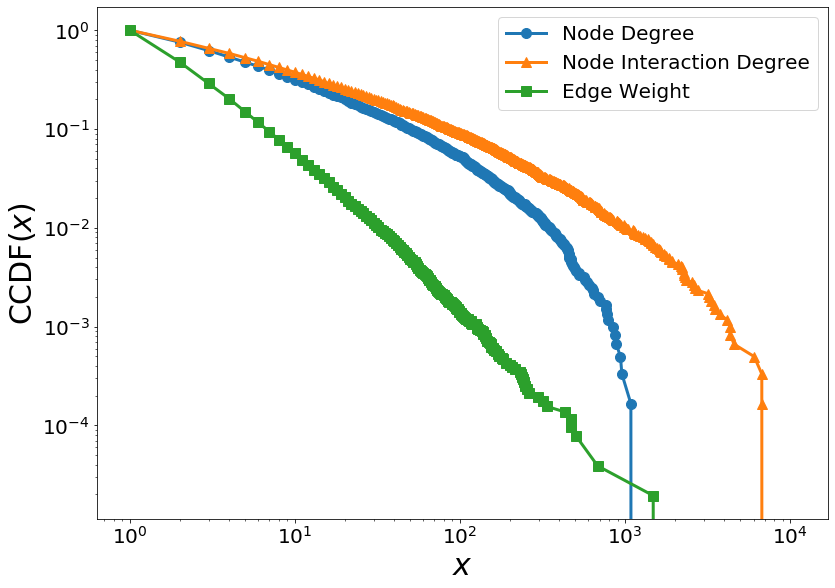

In [173]:
fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

file = 'degree/Distributions.json'
dist = get_df(file)

toPlot = ['degDist', 'weightDist', 'edgeDist']
labels = ['Node Degree', 'Node Interaction Degree', 'Edge Weight']
markers = ['o','^','s']
index = ['degree', 'weight', 'eweight']

for j in range(3):
    degdist = map(lambda x: (x[index[j]], x['freq']), dist.iloc[0][toPlot[j]])
    dd = sorted(list(degdist), key = lambda x: x[0])

    cumsum = np.array([sum(list(map(lambda x: x[1], dd[:i]))) for i in range(len(dd))])
    ccdf = 1 - cumsum/cumsum[-1]
    print(ccdf)

    ax.plot(list(map(lambda x: x[0], dd)), ccdf, label=labels[j], marker = markers[j],markersize=10, linewidth=3)

ax.legend(fontsize=20)
ax.set_xscale('log')
ax.set_xlabel('$x$',fontsize = 30)
ax.set_yscale('log')
ax.set_ylabel('CCDF$(x)$',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('Graphs/Distributions.png')
plt.show()

# Degree Results for sampled data

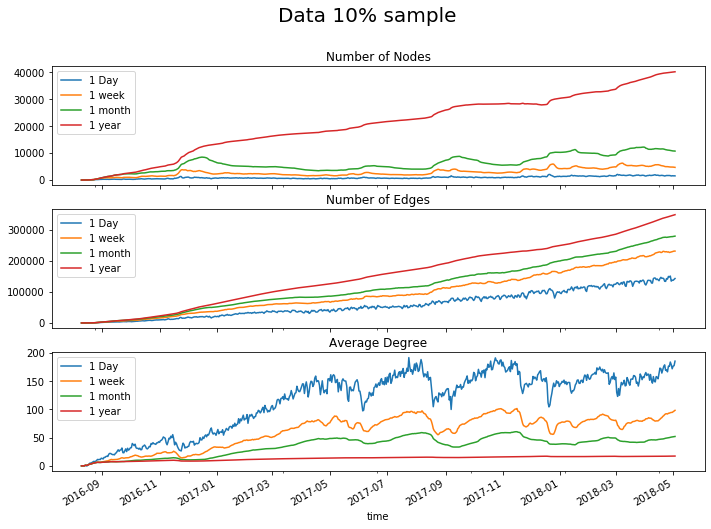

In [108]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=a4_dims, sharex=True)

file = "degree/DegBasic0.1.json"
prepare_file(file)
degdf = get_df("degree/tmp.json")

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
toPlot = ['vertices','edges','avgdeg']
names = ['Number of Nodes', 'Number of Edges', 'Average Degree']

fig.suptitle('Data 10% sample',fontsize=20)

for i, ax in enumerate(axes.flatten()):
    for j, w in enumerate(windows):
        deg = degdf[degdf['windowsize']==w]
        deg['avgdeg'] = np.where(deg['vertices']>0,2*deg['edges']/deg['vertices'],0)
        deg.plot(x='time',y=toPlot[i], ax=ax, label = window_names[j])
    ax.set_title(names[i])
    #ax.set_yscale('log')
    ax.legend()
    
plt.show()

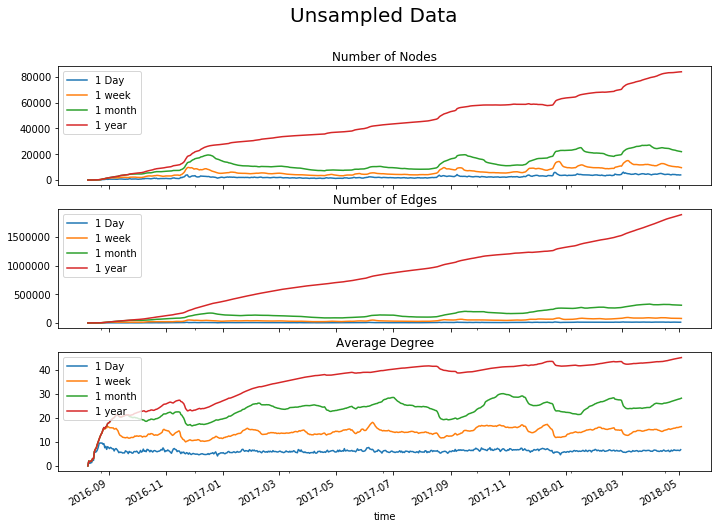

In [139]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=a4_dims, sharex=True)

file = "degree/degreewindows.json"
degdf = get_df(file)

windows = [86400000, 604800000, 2592000000, 31536000000]
window_names = ['1 Day', '1 week', '1 month', '1 year']
toPlot = ['vertices','edges','avgdeg']
names = ['Number of Nodes', 'Number of Edges', 'Average Degree']

for i, ax in enumerate(axes.flatten()):
    for j, w in enumerate(windows):
        deg = degdf[degdf['windowsize']==w]
        deg['avgdeg'] = np.where(deg['vertices']>0,2*deg['edges']/deg['vertices'],0)
        deg.plot(x='time',y=toPlot[i], ax=ax, label = window_names[j])
    ax.set_title(names[i])
    #ax.set_yscale('log')
    ax.legend()
    
fig.suptitle('Unsampled Data',fontsize=20)
plt.show()

# Connected Components Top 5

## Configuration model: data creation

This part is to get the data for the configuration model, no need to run again.

In [2]:
file = "RaulWeek.csv"
df = pd.read_csv(file, " ", names = ['time', 'src', 'dst'])
startTime = df.iloc[0]['time']
startTime = startTime - startTime%10
endTime = startTime + 168*3600
bin_range = np.linspace(startTime, endTime, 169)

outfile = "CC/cctop5configTWO.json"
ex = 5

bins = pd.cut(df['time'], bin_range)
windowed = df.groupby(bins)

k = 0
f = open(outfile, 'w')
f.write("{\"views\":[")
for win, frame in windowed:
    print(k)
    G = nx.Graph()
    edgelist = [(frame.iloc[i]['src'], frame.iloc[i]['dst']) for i in range(len(frame))]
    G.add_edges_from(edgelist)
    LCC_runs = np.zeros(ex)
    GT2_runs = np.zeros(ex)
    island_runs = np.zeros(ex)
    for i in range(ex):
        H = nx.configuration_model([d for n, d in G.degree()])
        cc = nx.connected_components(H)
        sortedcc = sorted(cc, key=len, reverse=True)
        cc = [len(c) for c in sortedcc]
        total = len(cc)
        island_runs[i] = len([c for c in cc if c == 1])
        vertices = sum(cc)
        GT2_runs[i] = len([c for c in cc if c>2])
        LCC_runs[i] = cc[0]/vertices if vertices > 0 else 0
        top5 = '['+','.join(list(map(str,cc[:5])))+']'
    proportion, psd = LCC_runs.mean(), LCC_runs.std()
    clustersGT2, csd = GT2_runs.mean(), GT2_runs.std()
    totalIslands, tsd = LCC_runs.mean(), LCC_runs.std()
    text ="{\"time\": "+str(int(1000*win.left))+", \"top5\": "+top5+", \"total\": "+str(total)+", \"proportion\": "+str(proportion)+", \"propsd\": "+str(psd)+", \"totalIslands\": "+str(totalIslands)+", \"clustersGT2\": "+str(clustersGT2)+"} \n"
    f.write(text)
    k+=1
    
f.write("]}")
f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167


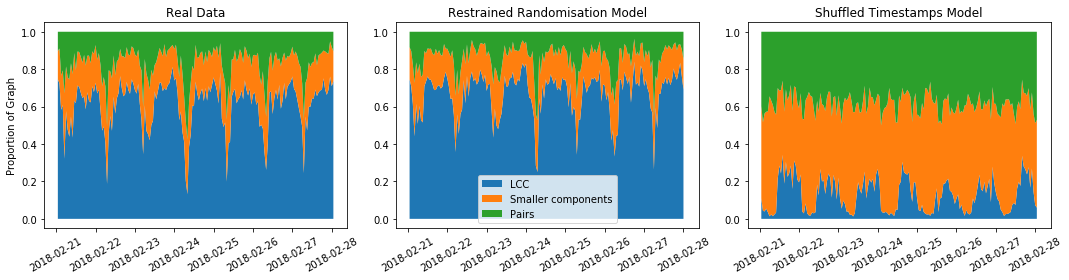

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharex=True)

files = ["CC/cctop5hr.json", "cc/cctop5config.json", "CC/cc1hrtop5shuffled.json"]
titles = ["Real Data", "Restrained Randomisation Model", "Shuffled Timestamps Model"]

for j, ax in enumerate(axes.flatten()):
    file = files[j]
    prepare_file(file)
    df = get_df("tmp.json")

    df = df[df['proportion']>0]
    df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
    df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
    df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion']-df['totalIslands'],0)

    intervals = np.zeros((2,len(df)))
    times = np.array(df['time'])

    intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
    intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/df['vertices']

    ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
    ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
    ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs')
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(titles[j])
    if j==0:
        ax.set_ylabel('Proportion of Graph')
    if j==1:
        ax.legend(loc = 'lower center')

plt.tight_layout()
plt.savefig('Graphs/CCReal.png')
plt.show()

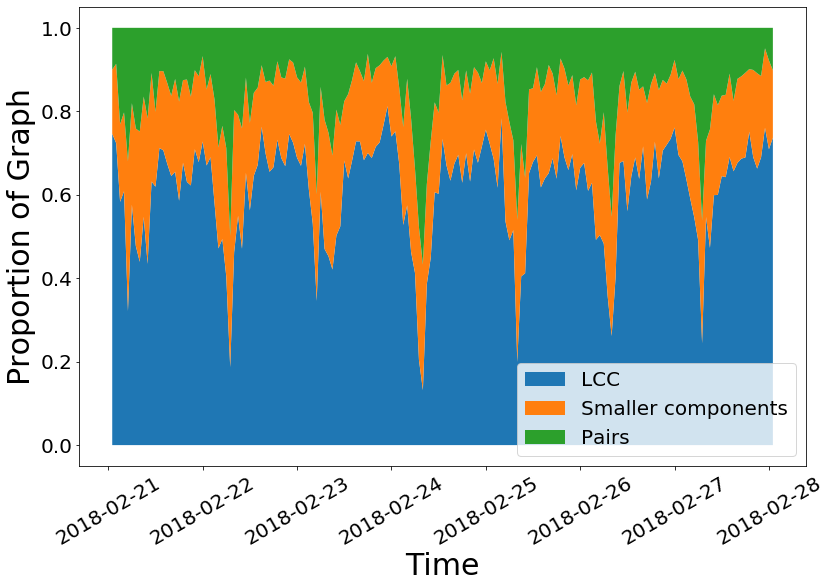

In [140]:
fig, ax = plt.subplots(figsize=a4_dims)

files = ["CC/cctop5hr.json", "cc/cctop5config.json", "CC/cc1hrtop5shuffled.json"]
titles = ["Real Data", "Restrained Randomisation Model", "Shuffled Timestamps Model"]

for j in range(1):
    file = files[j]
    prepare_file(file)
    df = get_df("tmp.json")

    df = df[df['proportion']>0]
    df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
    df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
    df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion']-df['totalIslands'],0)

    intervals = np.zeros((2,len(df)))
    times = np.array(df['time'])

    intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
    intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/(df['vertices'] - df['totalIslands'])

    ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
    ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
    ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs')
    ax.xaxis.set_tick_params(rotation=30)
    #ax.set_title(titles[j])
    ax.set_ylabel('Proportion of Graph',fontsize=30)
    ax.legend(loc = 'lower right',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('Time', fontsize=30)

plt.tight_layout()
plt.savefig('Graphs/CCReal.png')
plt.show()

0.560957953770827
0.12857144


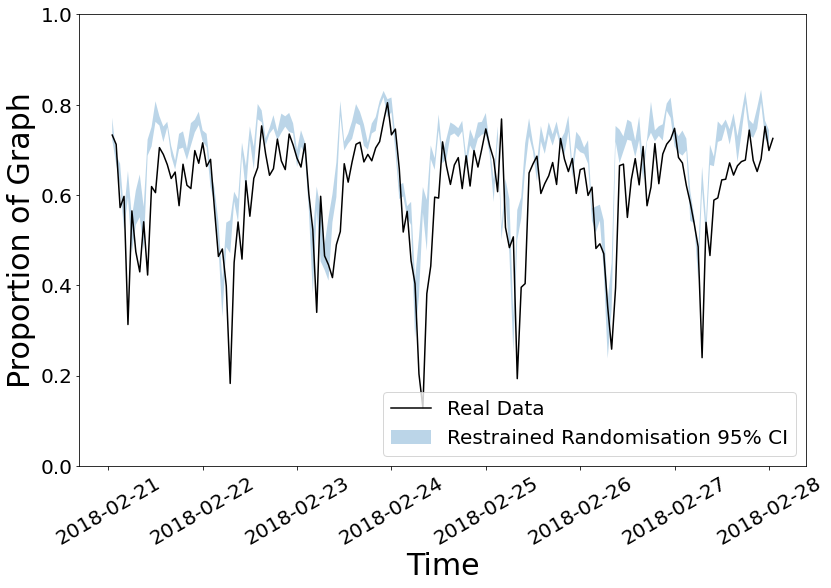

In [34]:
fig, ax = plt.subplots(figsize=a4_dims)

files = ["CC/cctop5hr.json", "cc/cctop5configTWO.json"]
titles = ["Real Data", "Restrained Randomisation Model"]

trough=79

# Plot rest rand file with errorbars
prepare_file(files[1])
df = get_df("tmp.json")
df = df[df['proportion']>0]
df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']

times = np.array(df['time'])

ax.fill_between(times, df['proportion']-1.96*df['propsd']/np.sqrt(5), df['proportion']+1.96*df['propsd']/np.sqrt(5), alpha=0.3, label="Restrained Randomisation 95% CI" )

lb = df['proportion']-1.96*df['propsd']/np.sqrt(5)

print(lb.iloc[trough])

prepare_file(files[0])
df = get_df("tmp.json")
df = df[df['proportion']>0]
df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
print(df.iloc[trough]['proportion'])
times = np.array(df['time'])

ax.plot(times,df['proportion'],color='black', label= "Real Data")

#ax.plot(times, lb - df['proportion'])
# print(np.mean(lb - df['proportion']))

ax.legend(loc = 'lower right',fontsize=20)

# for j in range(1):
#     file = files[j]
#     prepare_file(file)
#     df = get_df("tmp.json")

#     df = df[df['proportion']>0]
#     df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
#     df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
#     df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion']-df['totalIslands'],0)

#     intervals = np.zeros((2,len(df)))
#     times = np.array(df['time'])

#     intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
#     intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/(df['vertices'] - df['totalIslands'])

#     ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
#     ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
#     ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs')
#     ax.xaxis.set_tick_params(rotation=30)
#     #ax.set_title(titles[j])
#     ax.set_ylabel('Proportion of Graph',fontsize=30)
#     ax.legend(loc = 'lower right',fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     ax.set_xlabel('Time', fontsize=30)

ax.set_ylabel('Proportion of Graph',fontsize=30)
ax.xaxis.set_tick_params(rotation=30)
ax.set_xlabel('Time', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('Graphs/CCReal2.png')
plt.show()

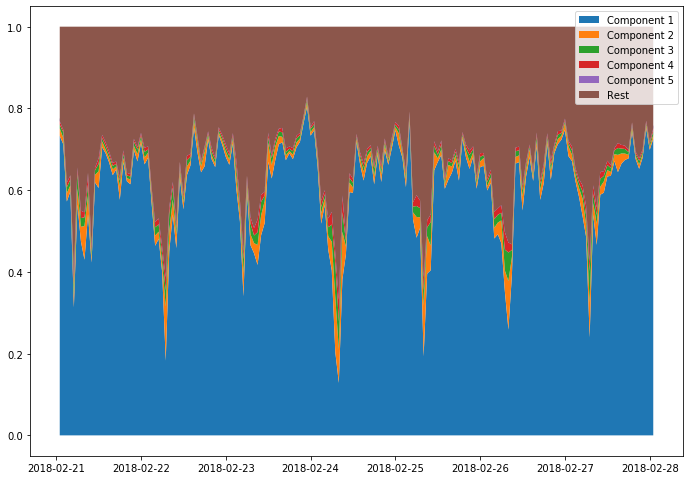

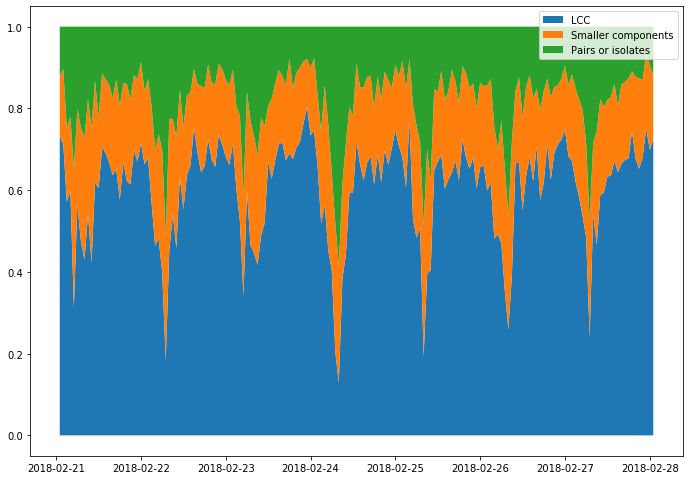

In [8]:
fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

file = "cc/cctop5hr.json"
prepare_file(file)
df = get_df("tmp.json")

df = df[df['proportion']>0]
df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion'],0)

intervals = np.zeros((6,len(df)))
times = np.array(df['time'])
for i in range(6):
    intervals[i,:] = df.apply(lambda row: sum(row['top5'][:i]), axis=1)/df['vertices']
    
for i in range(1,6):
    ax.fill_between(times, intervals[i-1,:],intervals[i,:], label = "Component "+str(i))
    
ax.fill_between(times,intervals[4,:],1.0,label='Rest')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

intervals = np.zeros((2,len(df)))
times = np.array(df['time'])

intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/df['vertices']

ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs or isolates')
ax.legend()
plt.show()

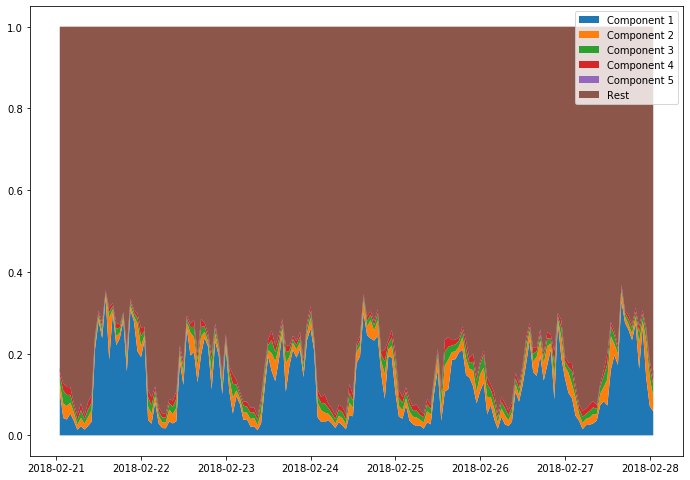

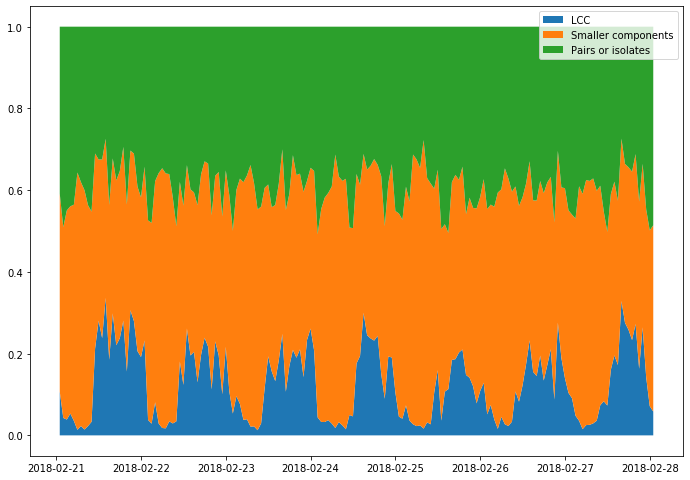

In [61]:
fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

file = "cc/cc1hrtop5shuffled.json"
prepare_file(file)
df = get_df("tmp.json")

df = df[df['proportion']>0]
df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion'],0)

intervals = np.zeros((6,len(df)))
times = np.array(df['time'])
for i in range(6):
    intervals[i,:] = df.apply(lambda row: sum(row['top5'][:i]), axis=1)/df['vertices']
    
for i in range(1,6):
    ax.fill_between(times, intervals[i-1,:],intervals[i,:], label = "Component "+str(i))
    
ax.fill_between(times,intervals[4,:],1.0,label='Rest')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

intervals = np.zeros((2,len(df)))
times = np.array(df['time'])

intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/df['vertices']

ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs or isolates')
ax.legend()
plt.show()

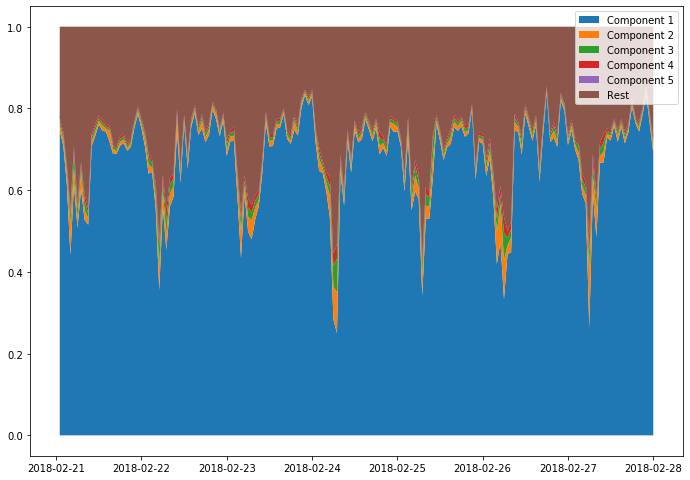

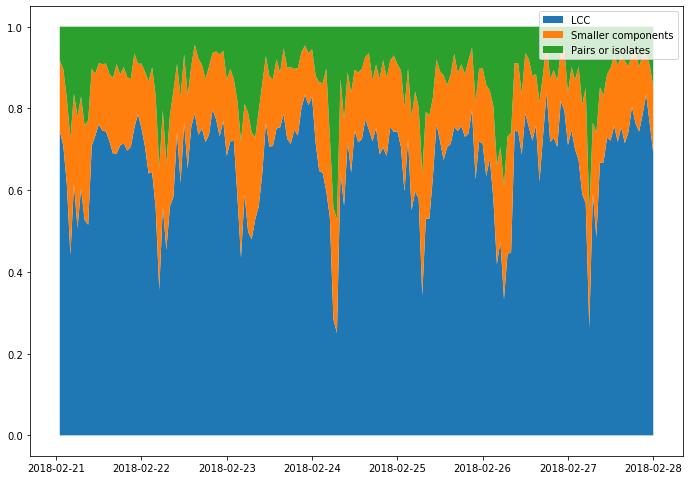

In [60]:
fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

file = "cc/cctop5config.json"
prepare_file(file)
df = get_df("tmp.json")

df = df[df['proportion']>0]
df = df[df.apply(lambda row: len(row['top5'])>1,axis=1)]
df = df['2018-02-21 01:00:00':'2018-02-28 01:00:00']
df['vertices'] = np.where(df['proportion']>0.0,df.apply(lambda row: row['top5'][0], axis=1)/df['proportion'],0)

intervals = np.zeros((6,len(df)))
times = np.array(df['time'])
for i in range(6):
    intervals[i,:] = df.apply(lambda row: sum(row['top5'][:i]), axis=1)/df['vertices']
    
for i in range(1,6):
    ax.fill_between(times, intervals[i-1,:],intervals[i,:], label = "Component "+str(i))
    
ax.fill_between(times,intervals[4,:],1.0,label='Rest')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

intervals = np.zeros((2,len(df)))
times = np.array(df['time'])

intervals[0,:]=df.apply(lambda row: row['top5'][0], axis=1)/df['vertices']
intervals[1,:]=intervals[0,:]+2*(df['total'] - df['clustersGT2'] - df['totalIslands'])/df['vertices']

ax.fill_between(times, 0.0, intervals[0,:], label = "LCC")
ax.fill_between(times, intervals[0,:],intervals[1,:], label = 'Smaller components')
ax.fill_between(times, intervals[1,:], 1.0, label = 'Pairs or isolates')
ax.legend()
plt.show()